In [1]:
# Reset environment for a new run
# %reset -f

# Load libraries
from os.path import join # for joining file pathnames
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Set Pandas display options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

wineDf = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/winequality.csv",
  encoding='latin-1')
wineDf.columns = ['fixed acidity','volatile acidity','citric acid',
                     'residual sugar','chlorides','free sulfur dioxide',
                     'total sulfur dioxide','density','pH',
                     'sulphates','alcohol','quality']
wineDf.head()

2023-06-30 17:27:33.021884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 17:27:48.692903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.3,0.4,20.7,0.0,45.0,170.0,1.0,3.0,0.5,8.8,6
1,6.3,0.3,0.3,1.6,0.0,14.0,132.0,1.0,3.3,0.5,9.5,6
2,8.1,0.3,0.4,6.9,0.1,30.0,97.0,1.0,3.3,0.4,10.1,6
3,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6
4,7.2,0.2,0.3,8.5,0.1,47.0,186.0,1.0,3.2,0.4,9.9,6


<Axes: >

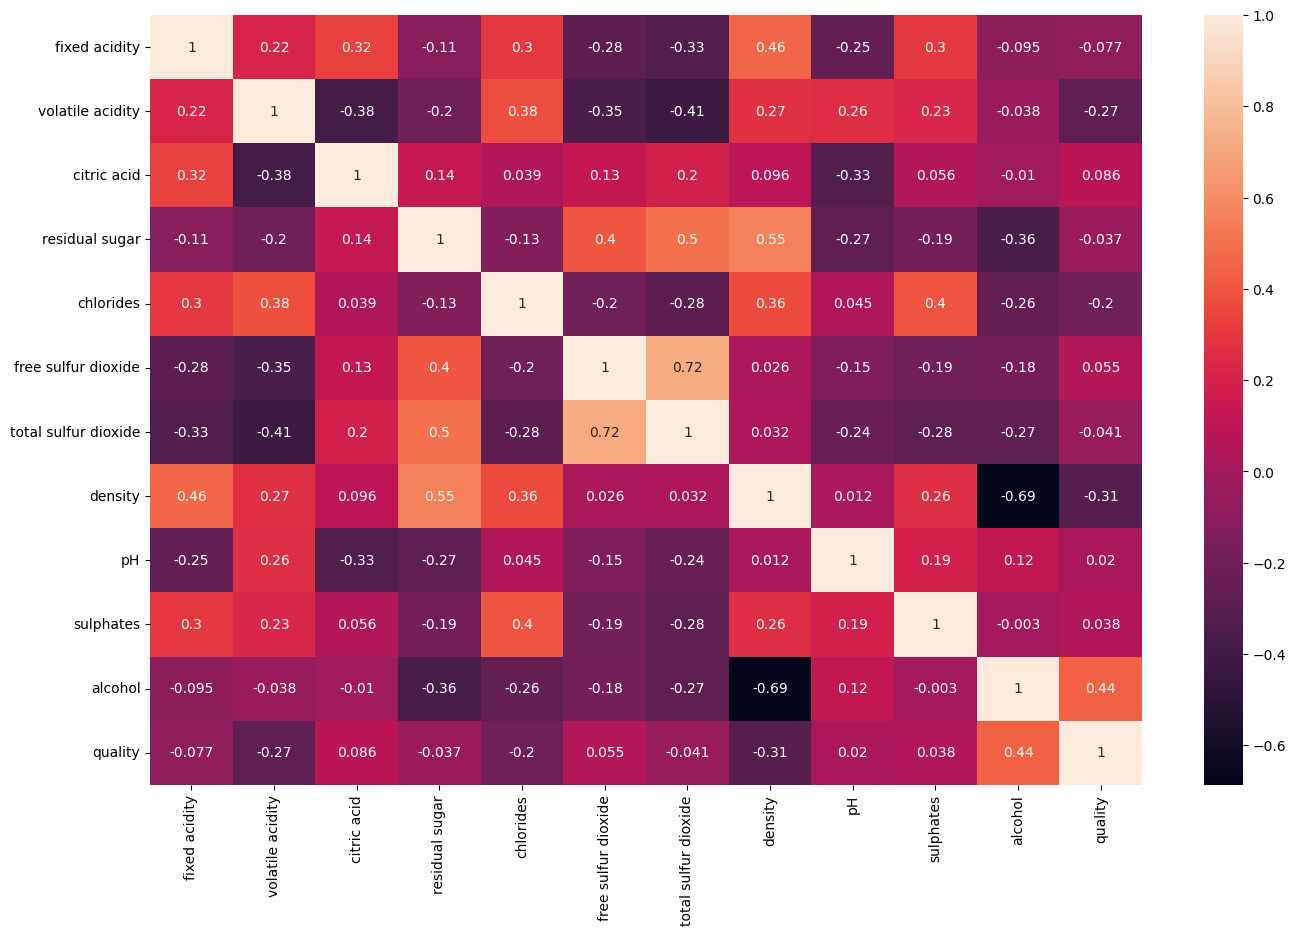

In [2]:
corr_wineDf = wineDf.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr_wineDf, annot=True)

In [3]:
#@title Define function to validate data

def test_data_schema(input_data, schema):
  """Tests that the datatypes and ranges of values in the dataset
    adhere to expectations.

    Args:
      input_function: Dataframe containing data to test
      schema: Schema which describes the properties of the data.
  """

  def test_dtypes():
    for column in schema.keys():
      assert input_data[column].map(type).eq(
          schema[column]['dtype']).all(), (
          "Incorrect dtype in column '%s'." % column
      )
    print('Input dtypes are correct.')

  def test_ranges():
    for column in schema.keys():
      schema_max = schema[column]['range']['max']
      schema_min = schema[column]['range']['min']
      # Assert that data falls between schema min and max.
      assert input_data[column].max() <= schema_max, (
          "Maximum value of column '%s' is too low." % column
      )
      assert input_data[column].min() >= schema_min, (
          "Minimum value of column '%s' is too high." % column
      )
    print('Data falls within specified ranges.')

  test_dtypes()
  test_ranges()

In [4]:
wineDf.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0,6497.0
mean,7.2,0.3,0.3,5.4,0.1,30.5,115.7,1.0,3.2,0.5,10.5,5.8
std,1.3,0.2,0.1,4.8,0.0,17.7,56.5,0.0,0.2,0.1,1.2,0.9
min,3.8,0.1,0.0,0.6,0.0,1.0,6.0,1.0,2.7,0.2,8.0,3.0
25%,6.4,0.2,0.2,1.8,0.0,17.0,77.0,1.0,3.1,0.4,9.5,5.0
50%,7.0,0.3,0.3,3.0,0.0,29.0,118.0,1.0,3.2,0.5,10.3,6.0
75%,7.7,0.4,0.4,8.1,0.1,41.0,156.0,1.0,3.3,0.6,11.3,6.0
max,15.9,1.6,1.7,65.8,0.6,289.0,440.0,1.0,4.0,2.0,14.9,9.0


In [5]:
wine_schema = {
    'fixed acidity': {
        'range': {
            'min': 3.8,
            'max': 15.9
        },
        'dtype': float,
    },
    'volatile acidity': {
        'range': {
            'min': , # describe() rounds up this value, be careful
            'max':
        },
        'dtype': ,
    },
    'citric acid': {
        'range': {
            'min': ,
            'max':
        },
        'dtype': ,
    }
}

print('Validating wine data against data schema...')
test_data_schema(wineDf, wine_schema)

SyntaxError: expression expected after dictionary key and ':' (2528317187.py, line 11)

In [ ]:
wine_schema = {
    'fixed acidity': {
        'range': {
            'min': 3.7,
            'max': 15.9
        },
        'dtype': float,
    },
    'volatile acidity': {
        'range': {
            'min': 0.08,  # minimum value
            'max': 1.6   # maximum value
        },
        'dtype': float,    # data type
    },
    'citric acid': {
        'range': {
            'min': 0.0, # minimum value
            'max': 1.7  # maximum value
        },
        'dtype': float,   # data type
    }
}

print('Validating wine data against data schema...')
test_data_schema(wineDf, wine_schema)

In [6]:
wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality',inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)

In [7]:
def normalizeData(arr):
  stdArr = np.std(arr)
  meanArr = np.mean(arr)
  arr = (arr-meanArr)/stdArr
  return arr

for str1 in wineFeatures.columns:
   wineFeatures[str1] = normalizeData(wineFeatures[str1])

In [8]:
import unittest

def test_input_dim(df, n_rows, n_columns):
  assert len(df) == n_rows, "Unexpected number of rows."
  assert len(df.columns) == n_columns, "Unexpected number of columns."
  print('Engineered data has the expected number of rows and columns.')

def test_nulls(df):
  dataNulls = df.isnull().sum().sum()
  assert dataNulls == 0, "Nulls in engineered data."
  print('Engineered features do not contain nulls.')

In [9]:
#@title Test dimensions of engineered data
wine_feature_rows = 6497 #@param
wine_feature_cols = 11 #@param
test_input_dim(wineFeatures,
               wine_feature_rows,
               wine_feature_cols)

Engineered data has the expected number of rows and columns.


In [10]:
test_nulls(wineFeatures)

Engineered features do not contain nulls.


In [11]:
splitIdx = wineFeatures.shape[0]*8/10
wineFeatures.iloc[0:splitIdx,:].describe()

TypeError: cannot do positional indexing on RangeIndex with these indexers [5197.6] of type float

In [12]:
wineFeatures.iloc[splitIdx:-1,:].describe()

TypeError: cannot do positional indexing on RangeIndex with these indexers [5197.6] of type float

In [13]:
# Shuffle data
wineDf = wineDf.sample(frac=1).reset_index(drop=True)
# Recreate features and labels
wineFeatures = wineDf.copy(deep=True)
wineFeatures.drop(columns='quality',inplace=True)
wineLabels = wineDf['quality'].copy(deep=True)

In [14]:
baselineMSE = np.square(wineLabels[0:splitIdx]-np.mean(wineLabels[0:splitIdx]))
baselineMSE = np.sum(baselineMSE)/len(baselineMSE)
print(baselineMSE)

TypeError: cannot do slice indexing on RangeIndex with these indexers [5197.6] of type float

In [15]:
def showRegressionResults(trainHistory):
  """Function to:
   * Print final loss.
   * Plot loss curves.
  
  Args:
    trainHistory: object returned by model.fit
  """
  
  # Print final loss
  print("Final training loss: " + str(trainHistory.history['loss'][-1]))
  print("Final Validation loss: " + str(trainHistory.history['val_loss'][-1]))
  
  # Plot loss curves
  plt.plot(trainHistory.history['loss'])
  plt.plot(trainHistory.history['val_loss'])
  plt.legend(['Training loss','Validation loss'],loc='best')
  plt.title('Loss Curves')

2023-06-30 17:30:14.400285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-30 17:30:14.561811: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Final training loss: 0.6442010402679443
Final Validation loss: 0.6660435199737549


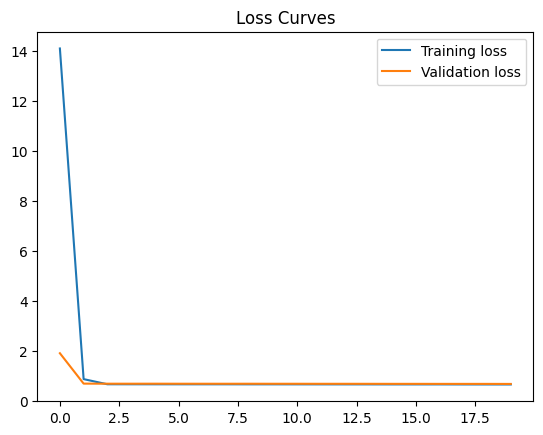

In [17]:
model = None
# Choose feature
wineFeaturesSimple = wineFeatures['alcohol']
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(units=1, activation='linear', input_dim=1))
# Specify the optimizer using the TF API to specify the learning rate
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
              loss='mse')
# Train the model!
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100, # set batch size here
                         validation_split=0.2,
                         verbose=0)
# Plot
showRegressionResults(trainHistory)

Final training loss: 0.611339807510376
Final Validation loss: 0.6347050666809082


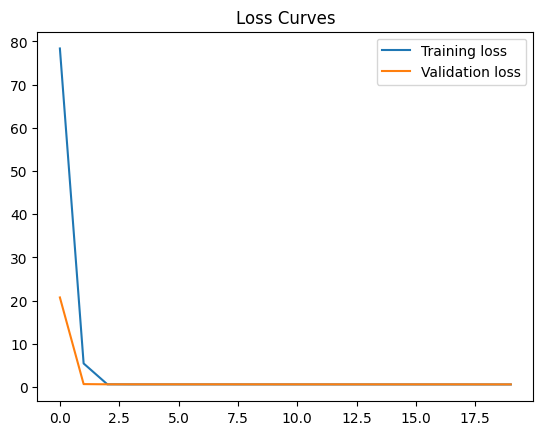

In [19]:
model = None
# Select features
wineFeaturesSimple = wineFeatures[['alcohol', 'volatile acidity']] # add second feature
# Define model
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             input_dim=wineFeaturesSimple.shape[1],
                             activation='linear'))
model.add(keras.layers.Dense(1, activation='linear')) # add second layer
# Compile
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=20,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

Final training loss: 0.611339807510376
Final Validation loss: 0.6347050666809082


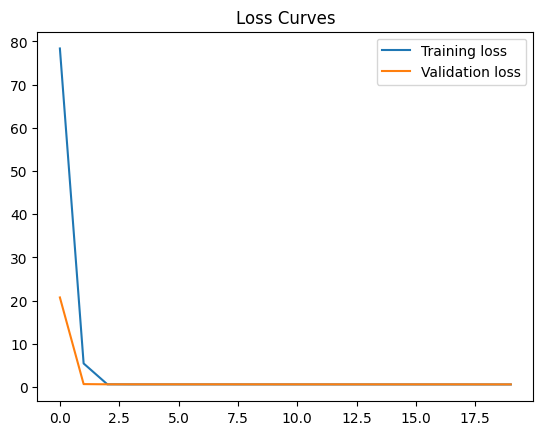

In [20]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             input_dim=wineFeaturesSimple.shape[1],
                             activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Fit
model.fit(wineFeaturesSimple,
          wineLabels,
          epochs=20,
          batch_size=100,
          validation_split=0.2,
          verbose=0)
# Plot results
showRegressionResults(trainHistory)

In [21]:
# Choose features
wineFeaturesSimple = wineFeatures[['alcohol', 'volatile acidity']] # add features
# Define
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             activation='relu',
                             input_dim=wineFeaturesSimple.shape[1]))
# Add more layers here
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=,
                         batch_size=,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

SyntaxError: invalid syntax (3529102289.py, line 16)

Final training loss: 0.5609846115112305
Final Validation loss: 0.5835567712783813


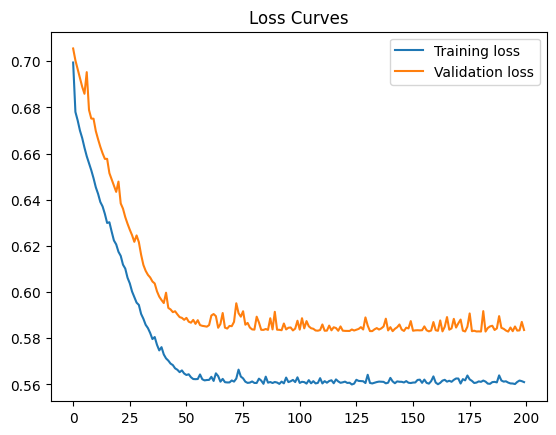

In [22]:
# Choose features
wineFeaturesSimple = wineFeatures[['alcohol','volatile acidity','chlorides','density']]
# Define
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSimple.shape[1],
                             activation='relu',
                             input_dim=wineFeaturesSimple.shape[1]))
# Add more layers here
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train
trainHistory = model.fit(wineFeaturesSimple,
                         wineLabels,
                         epochs=200,
                         batch_size=100,
                         validation_split=0.2,
                         verbose=0)
# Plot results
showRegressionResults(trainHistory)

Final training loss: 0.21868853271007538


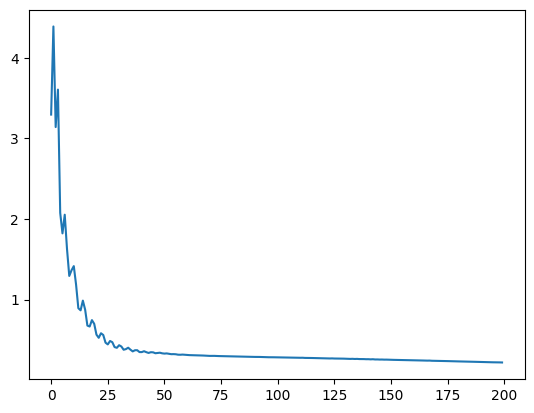

In [23]:
# Choose 10 examples
wineFeaturesSmall = wineFeatures[0:10]
wineLabelsSmall = wineLabels[0:10]
# Define model
model = None
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeaturesSmall.shape[1], activation='relu',
                             input_dim=wineFeaturesSmall.shape[1]))
model.add(keras.layers.Dense(wineFeaturesSmall.shape[1], activation='relu'))
model.add(keras.layers.Dense(1, activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(0.01), loss='mse') # set LR
# Train
trainHistory = model.fit(wineFeaturesSmall,
                        wineLabelsSmall,
                        epochs=200,
                        batch_size=10,
                        verbose=0)
# Plot results
print("Final training loss: " + str(trainHistory.history['loss'][-1]))
plt.plot(trainHistory.history['loss'])

Epoch 1/100
52/52 [==============================] - 1s 7ms/step - loss: 84.0251 - val_loss: 9.5179
Epoch 2/100
52/52 [==============================] - 0s 3ms/step - loss: 5.5731 - val_loss: 4.1060
Epoch 3/100
52/52 [==============================] - 0s 3ms/step - loss: 3.4770 - val_loss: 2.8073
Epoch 4/100
52/52 [==============================] - 0s 3ms/step - loss: 2.1005 - val_loss: 1.5959
Epoch 5/100
52/52 [==============================] - 0s 4ms/step - loss: 1.3436 - val_loss: 1.3065
Epoch 6/100
52/52 [==============================] - 0s 3ms/step - loss: 1.1893 - val_loss: 1.1977
Epoch 7/100
52/52 [==============================] - 0s 3ms/step - loss: 1.0959 - val_loss: 1.1158
Epoch 8/100
52/52 [==============================] - 0s 3ms/step - loss: 1.0334 - val_loss: 1.0456
Epoch 9/100
52/52 [==============================] - 0s 3ms/step - loss: 0.9727 - val_loss: 0.9966
Epoch 10/100
52/52 [==============================] - 0s 3ms/step - loss: 0.9252 - val_loss: 0.9461
Epoch 11

(0.4, 1.0)

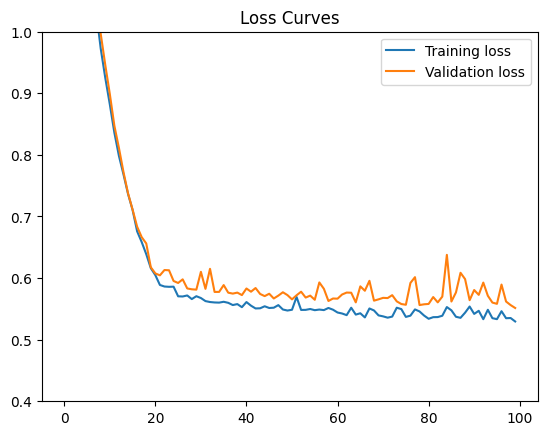

In [24]:
model = None
# Define
model = keras.Sequential()
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu',
                             input_dim=wineFeatures.shape[1]))
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu'))
model.add(keras.layers.Dense(wineFeatures.shape[1], activation='relu'))
model.add(keras.layers.Dense(1,activation='linear'))
# Compile
model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
# Train the model!
trainHistory = model.fit(wineFeatures, wineLabels, epochs=100, batch_size=100,
                         verbose=1, validation_split = 0.2)
# Plot results
showRegressionResults(trainHistory)
plt.ylim(0.4,1)